# 2019년 12월 12일  

[논문: Two cultures] 
https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726

- 분포의 가정이 틀리면 다 틀리 수 밖에 없다. 
- non-parametric 으로 가야한다. 

- No Free lunch 

Statistical learning 

SVM: 성능이 좋다. / 성능이 느리다(다중처리가 안된다.-gpu도 이용못하고 해서 컴퓨팅적으로 도태) 


이미지 인식 알고리즘 변천사 
- LeNet(1998): CNN 알고리즘의 시초
    - 28*28 -> Conv -> MaxPooling -> C -> P -> Flatten() -> FC1 -> FC2 -> FC3(output) = 10 
    - optimizer: SGD
    - lr (0.000 5->2->05->01) (loss 수렴시)
    - convolution을 통해 features를 뽑아서 학습 


딥러닝 

- AlexNet (2012)
    
- ZFNet (2013)
- VGG (2014)
- GoogleNet (2014)
- ResNet (2015) 

[문제]
1. overfitting
2. gradient vanishing 


feature map
- conv (filer) 곱해진 그림

Activation map 
- activation function 
- 공간을 왜곡시킨다. (공간을 펼칠 수 있다.) 
- overfitting 생긴다. 

- saturation gradient 현상 (dL/dW가 0이 되므로 W의 업데이트가 없어지는 현상)

kernel 
- weight 학습된 애 


CNN
- Hierarchical 특성 
- 색상정보까지 가지고 있어야 한다.(3차원) 
- filter가 많으면 데이터도 많아야한다. 



pooling 
- trainable 이 아닌애 
- 성능은 유지, 계속 속도를 줄여줌
- average pooling : 오버 피팅 덜 나게 하는 방법 (특징을 잘 못 뽑아낼 수 있음) 
- max pooling: 가장 큰 특징 
- 실용적인 접근에 있어서 많이 안쓰려고 하는 추세 (Stride를 더 많이 씀)

In [1]:
import tensorflow as tf

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# keras.models.Sequential 단점: single input, single output
# keras.models.Model: Model(inputs, outputs): multi input, output 가능 

11493376/11490434 [==============================] - 2s 0us/step


## beginner

In [1]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [2]:
# tf.keras.models.Sequential은 input, output 하나씩만 집어넣을 수 있다. 
# tensorflow.keras.Model: multi inputs, multi outputs

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 공부
# train_on_batch, fit_generator, fit, gradient_tape  (loss, optimizer, metrics)
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

## expert

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [10]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 채널 차원을 추가합니다.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

- numpy : mutable , gpu X 
- tensor : immuatble, gpu O, neural network만 지원한다. 

In [11]:
# tensor 
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
# composition 방법 (다중 상속 안하기 위해서) 
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

() 붙이는거 3가지 
- class, function, __callable 

옵션 넣는 3가지
- [상속 인스턴스, 문자열(default)] - numpy, [tf.nn] - tensor

In [16]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [17]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

tf.GradientTape를 사용하여 모델을 훈련합니다:

In [18]:
# tensor vector 되는 애들만 된다. 
# vectorization 연산  (difficult) 

@tf.function
def train_step(images, labels):
#     gradient tape 안에 들어가는 애들은 loss 함수 
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [19]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [21]:
EPOCHS = 2

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

에포크: 1, 손실: 0.08375329524278641, 정확도: 97.49239349365234, 테스트 손실: 0.05728616937994957, 테스트 정확도: 98.18000030517578
에포크: 2, 손실: 0.06444793939590454, 정확도: 98.06067657470703, 테스트 손실: 0.05624287202954292, 테스트 정확도: 98.25333404541016


Save and Load 

https://www.tensorflow.org/tutorials/keras/save_and_load

- weight/ 전체 

- callback - overriding (dir() - on_붙은 애들 가져올수 있다.)

tensor로 불러오는 것 
- decode, (?) 
- 속도는 좀더 빨랐다. 

ImageDataGenerator : 내부적으로는 PIL tech <br>
                     flow_(directory, dataframe)를 시켜야 next로 불러올 수 있다. <br>
                     fit_generator 
                     
                     
클래스별로 넣어놓으면 자동으로 클래스 이름 넣어준다. 

# Image

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [23]:
import pathlib
# os에 상관없이 /,\ 자동으로 바꿔준다. 
# get_file로 이미지 불러오는 것 
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
# glob, .. 등등 pathlib에 다 맞춰나서 편하다.

In [38]:
'__next__' in dir(data_dir.glob('*/*.jpg'))

True

In [35]:
# glob: 특정 format 찾아 주는 애 
# import glob이 있었는데, 이제는 pathlib에서 가져올 수 있다. 
image_count = len(list(data_dir.glob('*/*.jpg')))

In [39]:
# CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
# CLASS_NAMES

- ImageDataGenerator

In [40]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [41]:
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
# generator로들어가기 때문에 효율성에 있어서 
# 에폭당 데이터 몇개씩 줄여줄지 정하는 것 

In [42]:
# flow_from_directory -> fit_generator 
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
#                                                      batch_size=32,
                                                     shuffle=True,
                                                     target_size=(224,224))
# lasses = list(CLASS_NAMES)
# dir(classindex)로 보면 알아서 잘 잡아준다. 

Found 3670 images belonging to 5 classes.


In [44]:
# DirectoryIterator
type(train_data_gen)

keras_preprocessing.image.directory_iterator.DirectoryIterator

In [45]:
'__next__' in dir(train_data_gen)

True

In [46]:
# feature 순서 바꿔도 차이없는 것이 정형 데이터 (tensorflow 가 버전 2부터 정형 데이터에 강화되었다.) 
# 변수 순서 바꾸면 차이 있는 것이 비정형 데이터
dir(tf.data)
'''
자연어 처리
 'TFRecordDataset',
 'TextLineDataset'
'''

['Dataset',
 'DatasetSpec',
 'FixedLengthRecordDataset',
 'Options',
 'TFRecordDataset',
 'TextLineDataset',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'experimental']

- AUTO differentiate 

[컴퓨터가 미분하는 3가지 방법]
symbolic, 
auto differentiation (forward, backward)

[Detection] 
- classification
- localization (속도가 느려서, 속도 최적화과 관건) 
- Segementation: 대상 점 찾는 것 (한개 한개 찾는것: sementic segmentation, ..) 

## CNN 

In [47]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [48]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# CNN : reshape  -> fc layer 전에 flatten 시켜줘야한다. (ML) 
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# 픽셀 값을 0~1 사이로 정규화합니다.
train_images, test_images = train_images / 255.0, test_images / 255.0

In [49]:
model = models.Sequential()
# 보통 2의배수로 한다. (gpu 넣기가 좋다.)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [51]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [52]:
model.summary()

# 데이터가 몇개 들어올지 모르니까 None(None,26,...)으로 되어있는 것이다. 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [54]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 15s 252us/sample - loss: 0.0768 - accuracy: 0.9766


In [57]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

10000/1 - 1s - loss: 0.0266 - accuracy: 0.9840


## Image Classification 

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [59]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# 인터넷에서 불러오는 것 
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 6s 0us/step


In [60]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [63]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [69]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [105]:
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')
# binary하면 두개밖에 안 나누기 때문에 성능이 좀더 빠르다. 
# class_mode: One of "categorical", "binary", "sparse", "input", or None. Default: "categorical"

Found 2000 images belonging to 2 classes.


In [106]:
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              target_size=(150, 150),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [107]:
x, y = next(train_data_gen)

In [108]:
import matplotlib.pyplot as plt

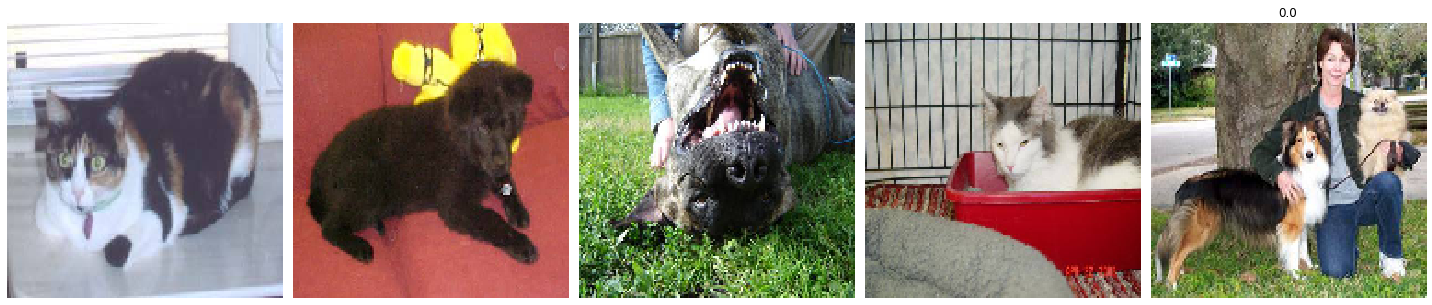

In [115]:
fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(x, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [116]:
# same: 똑같은 크기(범위 초과해서라도) 
# valid: 유효한 크기까지만 (에러 안날정도까지 해주는 것) 
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(150, 150 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [117]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 20736)            

In [123]:
# 할당하면 history를 볼 수 있다.
# history를 통해 learning curve 그릴 수 있다.
history = model.fit_generator(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen
)
'''
batch_size하면 속도가 좀더 빠르다. 
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_val // batch_size
'''

Epoch 1/5
63/63 [==============================] - 19s 300ms/step - loss: 0.6932 - accuracy: 0.4790 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
63/63 [==============================] - 19s 300ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
63/63 [==============================] - 19s 304ms/step - loss: 0.6932 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
63/63 [==============================] - 19s 298ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
63/63 [==============================] - 19s 301ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5000


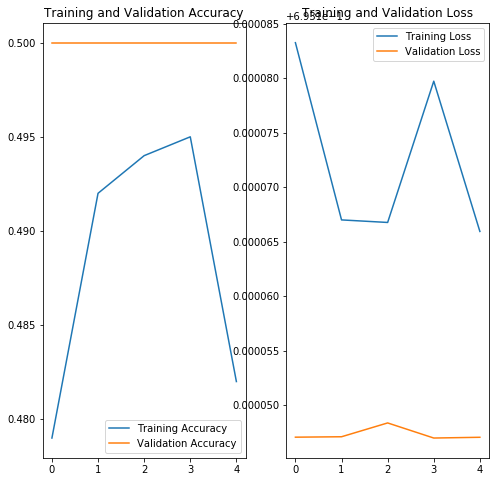

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

tensorflow
- hub : 모델 많다. 

https://tfhub.dev/s

- keras.application : 모델 많이 없다. 

In [127]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [128]:
# classifier: dense 까지 
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [129]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [130]:
# 4차원으로 넣어줘야한다. 
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________
